In [1]:
!pip install -Uq torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [2]:
import sys

from google.colab import drive
drive.mount('/content/drive')

!cp ./drive/Othercomputers/Comp/GNN/dataset.py ./

# Old way with conda env
# !pip install -q virtualenv
# !source /content/drive/MyDrive/colab_env/bin/activate;
# sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
print(torch.__version__)

2.2.1+cu121


In [4]:
from torch_geometric.data import DataLoader
from dataset import DessinsDataset
import torch_geometric

dataset = DessinsDataset('./drive/Othercomputers/Comp/GNN/data', None)
print("Dataset len =", len(dataset))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Dataset len =  1860
Device: cuda


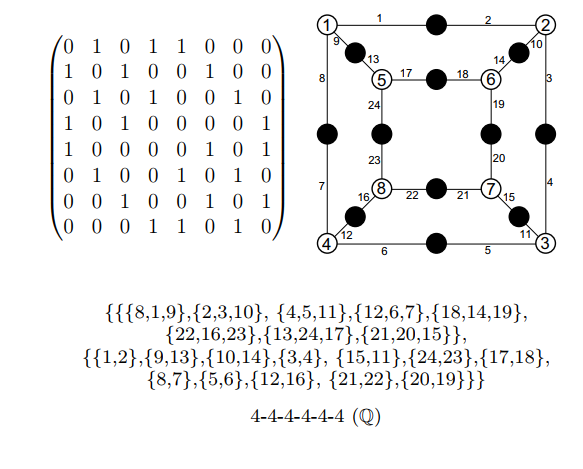

In [5]:
N = 0
print(dataset[N])
# print(dataset[N].edge_index.t()[:15])
# print("Edge weights = ", dataset[N].weight)
# print(dataset[N].x)
# print(dataset[N].y)

Data(edge_index=[2, 48], weight=[48], x=[20, 3], y=[1])


In [11]:
class_weights = [list(dataset.y).count(i)/len(dataset) for i in range(4)]
assert (sum(class_weights) == 1)

class_weights = torch.tensor(sorted(class_weights, reverse = True))
print("class_weights =", class_weights)

class_weights = tensor([0.4032, 0.3387, 0.2258, 0.0323])


In [12]:
dataset = dataset.shuffle()


train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of node features:{dataset.num_node_features}')
print(f'Number of classes:{dataset.num_classes}')

Number of training graphs: 1488
Number of test graphs: 372
Number of node features:3
Number of classes:4


Объявим функцию, формирующeю DataLoader'ы. Присвоим классам вероятности так, чтобы внутри батча соблюдался баланс классов.

In [15]:
from torch.utils.data import WeightedRandomSampler

def get_loader(dataset, batch_size, auto_balance = True):
  if auto_balance:
  # Вычисляем веса
    class_weights = [1/list(dataset.y).count(i) for i in range(4)]
    class_weights = torch.tensor(class_weights)

    #Присваиваем соответствующий вес каждому экземпляру в датасете
    #в соответствии с его классом

    sample_weights = [class_weights[data.y] for idx, data in enumerate(dataset)]

    sampler = WeightedRandomSampler(sample_weights, num_samples=
                                  len(sample_weights), replacement=True)

  else:
    sampler = None

  loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
  return loader


In [16]:
train_loader = get_loader(train_dataset, batch_size=512)
test_loader = get_loader(test_dataset, batch_size=256)

Проверим, что наши батчи на самом деле сбалансированны

In [17]:

sample_batch = list(list(train_loader)[0].y)
class_weights = [sample_batch.count(i)/len(sample_batch) for i in range(4)]
print("Class_weights = ",class_weights)

Class_weights =  [0.2265625, 0.2421875, 0.28125, 0.25]


Опишем нашу модель

In [18]:
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import GraphConv
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn import Sequential

In [19]:
from collections import OrderedDict
from torch.nn import ReLU
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, lin_layers=3):
        super(GCN, self).__init__()
        self.last_assigned_token = None

        self.num_layers = num_layers
        self.lin_layers = lin_layers

        self.convs = torch.nn.ModuleList([GCNConv(input_dim,hidden_dim)] + [GCNConv(hidden_dim,hidden_dim)\
                                                                          for i in range(num_layers-1)])
        self.batch_norm = BatchNorm1d(hidden_dim)
        self.lins = torch.nn.ModuleList([Linear(hidden_dim, hidden_dim)for i in range(lin_layers-1)] + [Linear(hidden_dim, output_dim)])

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x, edge_index, weights, batch):
        # 1. Obtain node embeddings
        for i in range(self.num_layers):
          x = self.convs[i](x, edge_index, edge_weight=weights)
          x = x.relu()

        #x = self.convs(x, edge_index, edge_weight=weights)

        #x = self.attention(x, edge_index, edge_attr = weights)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.batch_norm(x)
        self.last_assigned_token = x

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.6, training=self.training)


        for i in range(self.lin_layers-1):
          x = self.lins[i](x)
          x = x.relu()
          x = F.dropout(x, p=0.25, training=self.training)

        x = self.lins[self.lin_layers-1](x) #Final layer
        return x


model = GCN(dataset.num_node_features,hidden_dim=512,output_dim=dataset.num_classes, num_layers=2, lin_layers=1).to(device)
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(3, 512)
    (1): GCNConv(512, 512)
  )
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lins): ModuleList(
    (0): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [26]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
#model.reset_parameters()


optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    model.train()

    # Iterate in batches over the training dataset.
    for data in loader:
      data = data.to(device)
      #print("Ground = ", data.y[0:10])
      out = model(data.x, data.edge_index, data.weight.float(), data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.

def test(loader):

  model.eval()
  correct = 0

  # Iterate in batches over the training/test dataset.
  for data in loader:
    data = data.to(device)
    out = model(data.x, data.edge_index, data.weight.float(), data.batch)

    pred = out.argmax(dim=1) # Use the class with highest probability.
    correct += int((pred == data.y).sum())  # Check against ground-truth labels.

  return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
  train(train_loader)
  train_acc = test(train_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

print('--------------------')
test_acc = test(test_loader)
print(f'Test Acc: {test_acc:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.9570
Epoch: 002, Train Acc: 0.9530
Epoch: 003, Train Acc: 0.9630
Epoch: 004, Train Acc: 0.9530
Epoch: 005, Train Acc: 0.9590
Epoch: 006, Train Acc: 0.9731
Epoch: 007, Train Acc: 0.9731
Epoch: 008, Train Acc: 0.9691
Epoch: 009, Train Acc: 0.9724
--------------------
Test Acc: 0.9758


# Let us explain our model

In [27]:
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx

In [ ]:
#@title Fixed behavior of library functions
from math import sqrt
from typing import Any, Optional

import torch
from torch import Tensor

BACKENDS = {'graphviz', 'networkx'}
from math import sqrt
def visualize_graph(
    edge_index: Tensor,
    edge_weight: Optional[Tensor] = None,
    path: Optional[str] = None,
    backend: Optional[str] = None,
) -> Any:
    r"""Visualizes the graph given via :obj:`edge_index` and (optional)
    :obj:`edge_weight`.

    Args:
        edge_index (torch.Tensor): The edge indices.
        edge_weight (torch.Tensor, optional): The edge weights.
        path (str, optional): The path to where the plot is saved.
            If set to :obj:`None`, will visualize the plot on-the-fly.
            (default: :obj:`None`)
        backend (str, optional): The graph drawing backend to use for
            visualization (:obj:`"graphviz"`, :obj:`"networkx"`).
            If set to :obj:`None`, will use the most appropriate
            visualization backend based on available system packages.
            (default: :obj:`None`)
    """
    if edge_weight is not None:  # Normalize edge weights.
        edge_weight = edge_weight - edge_weight.min()
        edge_weight = edge_weight / edge_weight.max()

    if edge_weight is not None:  # Discard any edges with zero edge weight:
        mask = edge_weight > 1e-7
        edge_index = edge_index[:, mask]
        edge_weight = edge_weight[mask]

    if edge_weight is None:
        edge_weight = torch.ones(edge_index.size(1))

    if backend is None:
        backend = 'graphviz' if has_graphviz() else 'networkx'

    if backend.lower() == 'networkx':
        return _visualize_graph_via_networkx(edge_index, edge_weight, path)
    elif backend.lower() == 'graphviz':
        return _visualize_graph_via_graphviz(edge_index, edge_weight, path)

    raise ValueError(f"Expected graph drawing backend to be in "
                     f"{BACKENDS} (got '{backend}')")


def _visualize_graph_via_graphviz(
    edge_index: Tensor,
    edge_weight: Tensor,
    path: Optional[str] = None,
) -> Any:
    import graphviz

    suffix = path.split('.')[-1] if path is not None else None
    g = graphviz.Digraph('graph', format=suffix)
    g.attr('node', shape='circle', fontsize='11pt')

    for node in edge_index.view(-1).unique().tolist():
        g.node(str(node))

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        hex_color = hex(255 - round(255 * w))[2:]
        hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
        g.edge(str(src), str(dst), color=f'#{hex_color}{hex_color}{hex_color}')

    if path is not None:
        path = '.'.join(path.split('.')[:-1])
        g.render(path, cleanup=True)
    else:
        g.view()

    return g

Explainer training

In [28]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)



In [29]:
explainer

In [ ]:
from torch_geometric.explain import metric

explain_loader = get_loader(train_dataset[0:50], batch_size=50,auto_balance=False)
for data in explain_loader:
  data = data.to(device)
  explanation = explainer(data.x, data.edge_index, weights=data.weight.float(), batch = data.batch )
  fids = metric.fidelity(explainer,explanation)
  #print(fids)
  #print(metric.characterization_score(fids[0],fids[1]))
  #explanation.visualize_feature_importance(top_k=10)
  #explanation.visualize_graph(backend='graphviz')
  visualize_graph(explanation.edge_index, explanation.weights.float(), backend='graphviz')
  #print(explanation)


/content/drive/MyDrive/colab_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
untchd_dataset = DessinsDataset('./drive/Othercomputers/Comp/GNN/data', None)
untchd_dataset[0]

[([0, 12], 10), ([0, 5], 15), ([0, 2], 22), ([1, 2], 9), ([1, 7], 4), ([1, 4], 20), ([2, 0], 22), ([2, 1], 9), ([3, 4], 17), ([3, 5], 1), ([3, 15], 8), ([4, 1], 20), ([4, 3], 17), ([5, 0], 15), ([5, 3], 1), ([6, 7], 18), ([6, 8], 5), ([6, 8], 13), ([7, 1], 4), ([7, 6], 18), ([8, 6], 5), ([8, 6], 13), ([9, 10], 12), ([9, 17], 6), ([9, 13], 24), ([10, 9], 12), ([10, 14], 21), ([11, 12], 3), ([11, 13], 2), ([11, 19], 14), ([12, 0], 10), ([12, 11], 3), ([13, 9], 24), ([13, 11], 2), ([14, 10], 21), ([14, 15], 19), ([14, 18], 11), ([15, 3], 8), ([15, 14], 19), ([16, 17], 23), ([16, 18], 16), ([16, 19], 7), ([17, 9], 6), ([17, 16], 23), ([18, 14], 11), ([18, 16], 16), ([19, 11], 14), ([19, 16], 7)]


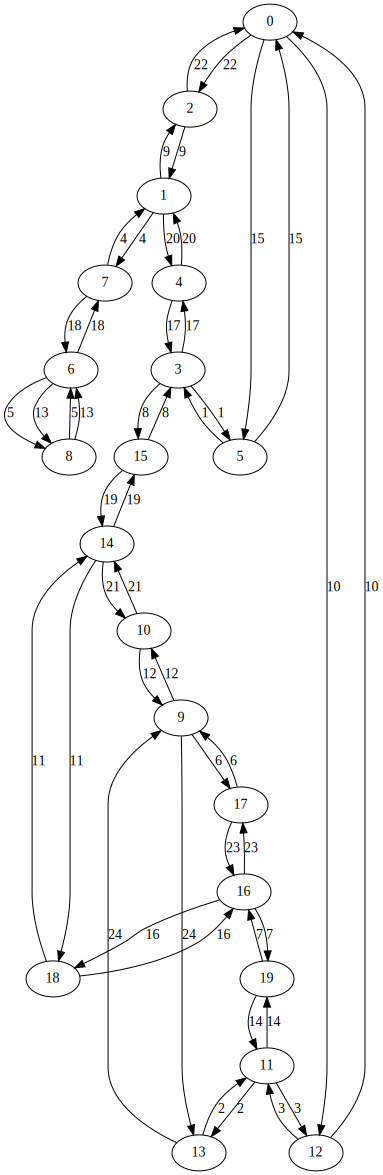

In [ ]:
import graphviz
inst = untchd_dataset[7]
print(list(zip(inst.edge_index.t().tolist(), inst.weight.tolist())))
g = graphviz.Digraph('graph')

for node in inst.edge_index.contiguous().view(-1).unique().tolist():
        g.node(str(node))

for (src, dst), w in zip(inst.edge_index.t().tolist(), inst.weight.float().tolist()):
    g.edge(str(src), str(dst), label = str(int(w)))

g.render(filename='graph_7')
g

tensor([[ 0, 12],
        [ 0,  5],
        [ 0,  2],
        [ 1,  2],
        [ 1,  7],
        [ 1,  4],
        [ 2,  0],
        [ 2,  1],
        [ 3,  4],
        [ 3,  5],
        [ 3, 15],
        [ 4,  1],
        [ 4,  3],
        [ 5,  0],
        [ 5,  3],
        [ 6,  7],
        [ 6,  8],
        [ 6,  8],
        [ 7,  1],
        [ 7,  6],
        [ 8,  6],
        [ 8,  6],
        [ 9, 10],
        [ 9, 17],
        [ 9, 13],
        [10,  9],
        [10, 14],
        [11, 12],
        [11, 13],
        [11, 19],
        [12,  0],
        [12, 11],
        [13,  9],
        [13, 11],
        [14, 10],
        [14, 15],
        [14, 18],
        [15,  3],
        [15, 14],
        [16, 17],
        [16, 18],
        [16, 19],
        [17,  9],
        [17, 16],
        [18, 14],
        [18, 16],
        [19, 11],
        [19, 16]])
tensor([10., 15., 22.,  9.,  4., 20., 22.,  9., 17.,  1.,  8., 20., 17., 15.,
         1., 18.,  5., 13.,  4., 18.,  5., 13., 12.,  6.,

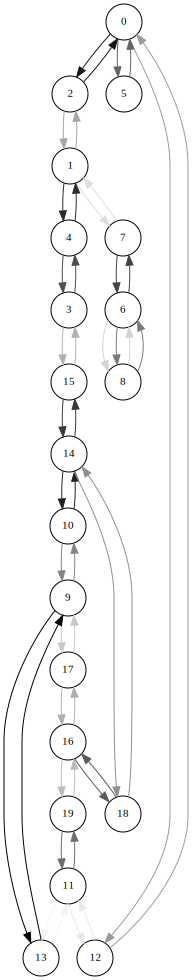

In [ ]:

print(inst.edge_index.t().contiguous())
print(inst.weight.float())
# print(inst.edge_index.stride())
# print(inst.edge_index.is_contiguous())
# print(inst.edge_index.contiguous().stride())
# print(inst.edge_index.shape)
#visualize_graph_via_networkx_custom(inst.edge_index, inst.weight.float())
dummy = torch.ones(len(inst.weight))
print(dummy)
visualize_graph(inst.edge_index, inst.weight.float(), backend='graphviz')

In [ ]:
mask = explanation.get('edge_mask')
mask

tensor([0.9169, 0.9084, 0.1076,  ..., 0.1582, 0.2153, 0.1950], device='cuda:0')

In [ ]:

inst = untchd_dataset[7]
print(list(zip(inst.edge_index.t().tolist(), mask.tolist())))
g = graphviz.Digraph('graph')

for node in inst.edge_index.contiguous().view(-1).unique().tolist():
        g.node(str(node))

for (src, dst), w, l in zip(inst.edge_index.t().tolist(), mask.tolist(), inst.weight.float().tolist()):
    hex_color = hex(255 - round(255 * w))[2:]
    hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
    print(f'#{hex_color}{hex_color}{hex_color}')
    g.edge(str(src), str(dst), color=f'#{hex_color}{hex_color}{hex_color}', label = str(int(l)))
    #g.edge(str(src), str(dst), label = str(int(w)))

g
g.render(filename='weighted_graph_7')

[([0, 12], 0.9169373512268066), ([0, 5], 0.9083887934684753), ([0, 2], 0.10756530612707138), ([1, 2], 0.9134374856948853), ([1, 7], 0.9136729836463928), ([1, 4], 0.06102251634001732), ([2, 0], 0.9062257409095764), ([2, 1], 0.899869441986084), ([3, 4], 0.894453763961792), ([3, 5], 0.9074568152427673), ([3, 15], 0.9009997844696045), ([4, 1], 0.8924412727355957), ([4, 3], 0.8890718221664429), ([5, 0], 0.8939303159713745), ([5, 3], 0.8949000835418701), ([6, 7], 0.9100123643875122), ([6, 8], 0.8885306119918823), ([6, 8], 0.9012983441352844), ([7, 1], 0.903549313545227), ([7, 6], 0.9011110067367554), ([8, 6], 0.9167360663414001), ([8, 6], 0.9023235440254211), ([9, 10], 0.872404932975769), ([9, 17], 0.9104412198066711), ([9, 13], 0.8967181444168091), ([10, 9], 0.89494389295578), ([10, 14], 0.9011191129684448), ([11, 12], 0.9026222229003906), ([11, 13], 0.8990713357925415), ([11, 19], 0.8966257572174072), ([12, 0], 0.9073136448860168), ([12, 11], 0.9056951403617859), ([13, 9], 0.90619343519210

'weighted_graph_7.pdf'

In [ ]:
visualize_graph(self.edge_index, edge_mask, path, backend)

NameError: name 'self' is not defined